<a href="https://colab.research.google.com/github/barakmam/ECG-Arrhythmia-Classification/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import time
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy.signal as sg

def checkDevice():
    if torch.cuda.is_available():
        torch.cuda.current_device()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    print("running calculations on: ", device)
    return device

# Data

In [ ]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

In [ ]:
!pip install wfdb
import wfdb

In [14]:
t = pd.read_csv("/content/100.csv")
annotation = pd.read_csv('/content/100annotations.txt', delimiter = "\t")

In [15]:
annotation

,Time Sample # Type Sub Chan Num,Aux
0,0:00.050 18 + 0 0 0,(N
1,0:00.214 77 N 0 0 0,NaN
2,0:01.028 370 N 0 0 0,NaN
3,0:01.839 662 N 0 0 0,NaN
4,0:02.628 946 N 0 0 0,NaN
...,...,...
2269,30:02.717 648978 N 0 0 0,NaN
2270,30:03.422 649232 N 0 0 0,NaN
2271,30:04.122 649484 N 0 0 0,NaN
2272,30:04.817 649734 N 0 0 0,NaN


In [17]:
77/360

0.21388888888888888

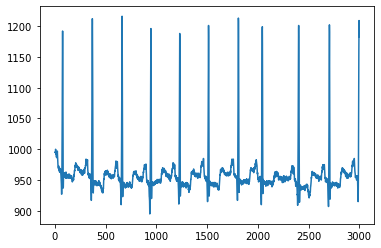

In [84]:
plt.plot(t["'MLII'"][:3000])

In [19]:
fileName = glob.glob("/content/physionet.org/files/mitdb/1.0.0/*.dat")
len(fileName)

48

In [9]:
signals, fields = wfdb.rdsamp('/content/physionet.org/files/mitdb/1.0.0/100', channels=[0], sampfrom=0)
display(signals)
display(fields)

array([[-0.145],
       [-0.145],
       [-0.145],
       ...,
       [-0.675],
       [-0.765],
       [-1.28 ]])

{'base_date': None,
 'base_time': None,
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'fs': 360,
 'n_sig': 1,
 'sig_len': 650000,
 'sig_name': ['MLII'],
 'units': ['mV']}

In [57]:
record = wfdb.rdrecord('/content/physionet.org/files/mitdb/1.0.0/100') 

In [10]:
# !git clone https://github.com/barakmam/ECG-Arrhythmia-Classification.git

Cloning into 'ECG-Arrhythmia-Classification'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
record.__dict__

In [ ]:
sum(record.__dict__["p_signal"])

In [ ]:
1011/record.__dict__["p_signal"][0, 1]
a = -6862.068965517242
b = -15553.846153846152
np.array([a, b])*(record.__dict__["p_signal"])[:13, :]

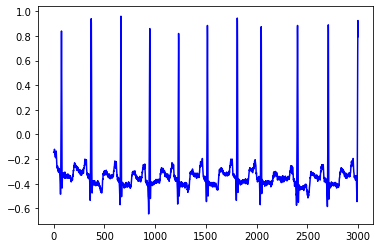

In [77]:
plt.plot(record.__dict__["p_signal"][:3000, 0],'b')
# plt.plot(record.__dict__["p_signal"][:1000, 1], 'k')

plt.show()

(0.0, 100.0)

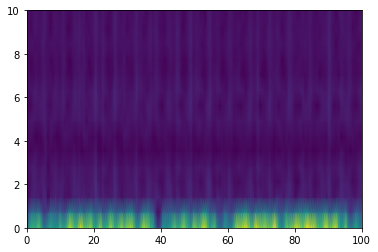

In [100]:
# s = sg.stft(record.__dict__["p_signal"][:4096, 0], fs=360)
f, t, Zxx = sg.stft(record.__dict__["p_signal"][:2**16, 1], fs=360, nperseg=512)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.ylim([0, 10])
plt.xlim([0, 100])


In [26]:
a = glob(input_dir)
a[3]

'/content/physionet.org/files/mitdb/1.0.0/212.atr'

In [ ]:
import multiprocessing as mp
import os.path as osp
import subprocess
from glob import glob

from tqdm import tqdm

input_dir = "/content/physionet.org/files/mitdb/1.0.0/*.atr"
ecg_data = sorted([osp.splitext(i)[0] for i in glob(input_dir)])
pbar = tqdm(total=len(ecg_data))


def run(file):
    params = ["python", "dataset-generation.py", "--file", file]
    subprocess.check_call(params)
    pbar.update(1)


if __name__ == "__main__":
    p = mp.Pool(processes=mp.cpu_count())
    p.map(run, ecg_data)

# Training loop


In [ ]:
def trainNet(net, n_epochs, batch_size, learning_rate, step, patience, valCalcFreq, train_loader, val_loader, device):
    # Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("learning_rate=", learning_rate)
    print("step=", step)
    print("patience=", patience)
    print("=" * 30)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    p = 0

    # Time for printing
    training_start_time = time.time()

    # Statistics:
    numDeleted = np.array([])
    train_acc_total = []
    val_acc_total = np.array([0])
    train_loss_total = np.array([])
    val_loss_total = np.array([])

    for epoch in range(n_epochs):
        train_loss = 0
        train_hits = 0
        train_samples_checked = 0
        start_time = time.time()

        net.train()
        for batch_idx, (x, labels) in enumerate(train_loader, 0):

            # Get inputs
            x, labels = x.to(device), labels.to(device)

            # Forward pass
            preds = net(x)
            loss = criterion(preds, labels)
            
            # Set the parameter gradients to zero, backward pass, optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update statstics:
            train_loss += loss.data
            train_hits += (preds.argmax(1) == labels).sum()
            train_samples_checked += len(preds)
            
        train_loss_total.append(train_loss.data / len(train_loader))
        train_acc_total.append(train_hits/train_samples_checked)

        print("Epoch [{}/{}]:\t Took {:.2f}s.\t Train: loss = {:.3f} Acc = {:.3f}"
              .format(epoch, n_epoch, time.time() - start_time, train_loss_total[-1], train_acc_total[-1]))

        if epoch % valCalcFreq == 0:
            # At the end of the epoch, do a pass on the validation set
            val_start_time = time.time()
            val_loss = 0
            val_hits = 0
            val_samples_checked = 0
            net.eval()
            with torch.no_grad():
                for (x, labels) in val_loader:
                    x, labels = x.to(device), labels.to(device)
                    # Forward pass
                    val_preds = net(x)
                    loss = criterion(val_preds, labels)

                     # Update statstics:
                    val_loss += loss.data
                    val_hits += (val_preds.argmax(1) == labels).sum()
                    val_samples_checked += len(labels)

            val_acc_total.append(val_hits / val_samples_checked)
            val_loss_total.append(val_loss / len(val_loader))
            
            print("Epoch [{}/{}]:\t Took {:.2f}s.\t Validation: loss = {:.3f} Acc = {:.3f}"
                  .format(epoch, epoch_n, time.time() - val_start_time, val_loss_total[-1], val_acc_total[-1]))
            if epoch > 0 and val_acc_total[-1] <= val_acc_total[-2]:
                p += 1
            else:
                p = 0
            if epoch == n_epochs:
                break

    print("Training finished, took {:.3f}s".format(time.time() - training_start_time))
    return net, train_acc_total, train_loss_total, val_acc_total, val_loss_total

# References

1. Dataset: [Moody GB, Mark RG. The impact of the MIT-BIH Arrhythmia Database. IEEE Eng in Med and Biol 20(3):45-50 (May-June 2001). (PMID: 11446209)](http://ecg.mit.edu/george/publications/mitdb-embs-2001.pdf)

2. Main paper: [ECG Arrhythmia Classification Using STFT-Based Spectrogram and Convolutional Neural Network](https://ieeexplore.ieee.org/abstract/document/8759878)